# Introduction to Concrete Data Science Project
_a study by Diana Giulietti_

The following data science notebook explores an academic paper by Zhao et al, _Experimental study on tensile strength development of concrete with manufactured sand_ ([DOI: 10.1016/j.conbuildmat.2017.01.093](http://dx.doi.org/10.1016/j.conbuildmat.2017.01.093)). This paper discusses:

1. mixing various amounts of ground stone powder into concrete and its effect on the concrete's resulting slump, compressive strength, and tensile strength. 
1. determining coefficients for a simple formula equating compressive strength to tensile strength
1. determining coefficients for a power function forcasting model for long-term tensile strength

The paper is interesting because, as its' supplementary material, it provides an extensive dataset of various process inputs for the concrete mixtures and each data points resulting slump, compressive strength, and tensile strength. This dataset allows for a thorough data science study into the process of making concrete mixtures.

The follow data science study will explore the data using descriptive statistics and data visualization to try to intuitively understand the dataset. It will then look into predictive modeling of the response variables, compressive strength and tensile strength, and compare the resulting functionality to that of the paper's formulas.

### Table of Contents

1. [Data Exploration](#Data-Exploration) </br>
    1.1. [How Manufactured Sand Process Parameters Impact the Response Variables](#Observing-Features-Relevent-to-Manufactured-Sand-Impact-Response-Variables) </br>
    1.2. [Estimating the Effect of SCMs on the Response Variables](#Back-filling-SCMs) </br>
    1.3. [Gaining a Overall Understanding of Each Feature in the Dataset](#Gaining-a-general-understanding-of-each-feature-in-the-dataset) </br>
2. [Predictive Modeling](#Predictive-Modeling) </br>
    2.1. [Compressive Strength Model](#Compressive-Strength-Model:-Setup) </br>
    2.2 [Extracting Process Input Feature Importance for Compressive Strength](#Extracting-Process-Input-Feature-Importance-for-Compressive-Strength) </br>
    2.3 [Tensile Strength Model: Linking Two Models](#Tensile-Strength-Model:-Linking-Two-Models) </br>
    2.4 [Mocking a Predictive Workflow](#Mocking-a-Predictive-Workflow) </br>
3. [Comparing Results to the Formulas from the Paper](#Comparing-Results-to-the-Formulas-from-the-Paper) </br>
4. [Conclusions](#Conclusions) </br>


    

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Exploration

Below is some basic and then more exploratory data anaylsis of this concrete data set. An example of 3 entries from the data is shown, along with a data dictionary summarizing some of the concrete-domain-specific features. Note that not every datapoint has an entry for every feature. The paper discusses 714 datapoints covering various concrete mixtures pulled in from multiple sources. The **response variables** for these experiments are **slump, compressive strength, and tensile strength**. The remaining features are concrete mixing **process variables**.

This exploration goes a bit deeper into:
1. Observing the response variables against the process variables relevent to manufactured sand
1. Understanding the effect of (estimated) supplemental cementitious materials (SCMs) quantity on the response variables
1. Gaining an general understanding of the distributions within each process variable feature and their relationships to the response variables.

In [92]:
df = pd.read_csv('concrete_dataset_cleaned.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(3)

,Source,compressive_strength_of_cement_MPa,tensile_strength_of_cement_MPa,curing_age_day,Dmax_of_crushed_stone_mm,stone_powder_content_in_sand_%,fineness_modulus_of_sand,W/B,water_to_cement_ratio_mw/mc,water_kg/m3,sand_ratio_%,slump_mm,"compressive_strength_fcu,t_MPa","splitting_tensile_strength_fst,t_MPa"
0,Zhaoetal[1],46.8,8.0,3.0,31.5,5.0,3.34,0.56,0.56,180.0,44.0,50.0,32.5,1.18
1,Zhaoetal[1],46.8,8.0,3.0,31.5,9.0,3.27,0.56,0.56,180.0,44.0,70.0,28.7,1.13
2,Zhaoetal[1],46.8,8.0,3.0,31.5,13.0,2.77,0.56,0.56,180.0,44.0,50.0,28.5,1.56


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Source                                714 non-null    object 
 1   compressive_strength_of_cement_MPa    463 non-null    float64
 2   tensile_strength_of_cement_MPa        439 non-null    float64
 3   curing_age_day                        714 non-null    float64
 4   Dmax_of_crushed_stone_mm              652 non-null    float64
 5   stone_powder_content_in_sand_%        674 non-null    float64
 6   fineness_modulus_of_sand              599 non-null    float64
 7   W/B                                   710 non-null    float64
 8   water_to_cement_ratio_mw/mc           704 non-null    float64
 9   water_kg/m3                           701 non-null    float64
 10  sand_ratio_%                          608 non-null    float64
 11  slump_mm           

### Data Dictionary

* **Dmax of crushed stone (mm)** -- max diameter of the crushed stone
* **Stone powder content in sand (%)** -- dataset is investigating the presence of manufactured sand (stone powder) on concrete. The feature tracks the mass percent of manufactured sand in natural sand
* **Fineness modulus of sand** -- describes the mean size of the particles in sand.
* **W/B or Water:Binder ratio** -- Binder is the cementitious materials which may contain Supplemental Cementing Materials (SCMs). SCMs work through both hydraulic or pozzolanic reactions to alter the properties (permeability, strength, etc) of hardened concrete or to produce concrete more economically. Examples of SCMS include fly ash, slag cement, and silica fume
* **Water to Cement ratio (mw/mc)** -- mass ratio of water to cementitious materials
* **Water (kg/m3)** -- Water Content, mass to volume content of water per cubic meter of mix (reduction factor)
* **Slump (mm)** -- refers to the consistency of the fresh concrete before it sets. Acceptable slump with depend on the equipment available and the application.

In [94]:
y_vars = ['slump_mm', 'compressive_strength_fcu,t_MPa', 'splitting_tensile_strength_fst,t_MPa']

### Observing Features Relevent to Manufactured Sand Impact Response-Variables

This paper is investigating the addition of ground stone to natural sand (producing "manufactured sand") and classifies their experiments in terms of nine mixtures, using two variables with three levels:

* **Sand ratio (%)**: 44, 36, and 34
* **Stone powder (%)**: 5, 9, and 13

In inspecting the data set, it is clear that these features to not closely match these mixtures. There are perhaps some modes around each one of those sand ratios, but stone powder precentages appear to vary widely between 0 and 40%. This does not impare the ability of fitting a regression model to this data, but it does raise come questions in how the paper presented it's data.

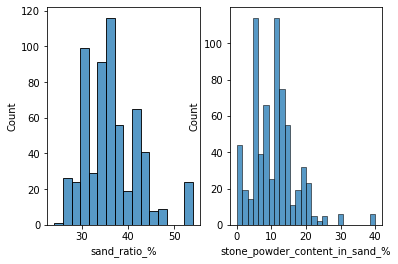

In [95]:
fig, axes = plt.subplots(1,2)
sns.histplot(data=df['sand_ratio_%'], ax=axes[0])
sns.histplot(data=df['stone_powder_content_in_sand_%'], ax=axes[1]);

Regardless, scatterplots with datapoint color-mapped to the response-variable values can shead some insight on to how these two particular features interact with slump, compressive strength, and tensile strength. The two relevant features, `stone powder content in sand` and `sand ratio`, are plotted on the x and y. Color and size of the datapoint dictate the response-variable value for each entry.

It could be argued that higher stone content generally leads to lower compressive strength and lower tensile strength and maybe even less slump. However, the relationship is not super clear. On top of this, this dataset is lacking in that it is not recorded which mixtures include admixtures or SCMs, so this relationship of stone powder % on the response-variables is inconclusive.

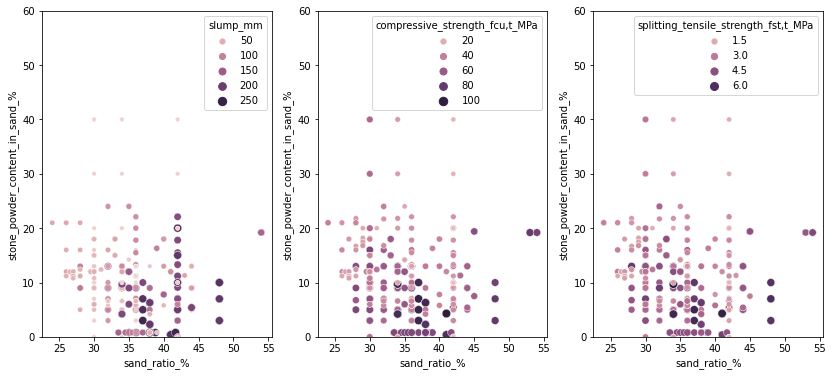

In [96]:
fig, axes = plt.subplots(1,3, figsize=(14,6))
sns.scatterplot(data=df, x='sand_ratio_%', y='stone_powder_content_in_sand_%', 
                hue='slump_mm', size='slump_mm', ax=axes[0]).set_ylim(0,60)
sns.scatterplot(data=df, x='sand_ratio_%', y='stone_powder_content_in_sand_%', 
                hue='compressive_strength_fcu,t_MPa', size='compressive_strength_fcu,t_MPa', ax=axes[1]).set_ylim(0,60)
sns.scatterplot(data=df, x='sand_ratio_%', y='stone_powder_content_in_sand_%', 
                hue='splitting_tensile_strength_fst,t_MPa', size='splitting_tensile_strength_fst,t_MPa', ax=axes[2]).set_ylim(0,60);

### Back filling SCMs

For some reason, the paper extensively discusses which SCMs were added and how it effected both the compressive and tensile strength. However, the dataset does not include this information. In order to estmiate the effect of SCMs quantity on the response variables, an approximation of the mass of SCMs can be made by subtracting information the water:cement feature from the water:binder feature, as the binder represents both cement and cementitious materials.

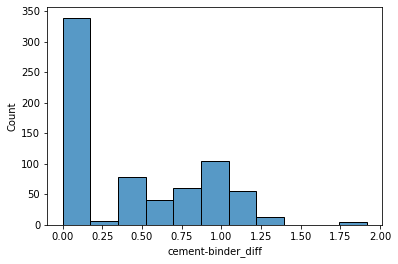

In [97]:
# This is sort of a hack to determine how much SCMs were added by subtracting the qty of cement from
# the qty of binder per the same unit of water. I wouldn't use this for anything quantitative
# but it gives some qualitative sense of additives.

df['cement-binder_diff'] = df.apply(
    lambda row: 1/row['W/B'] - 1/row['water_to_cement_ratio_mw/mc'],
    axis = 1)
sns.histplot(data=df['cement-binder_diff']);

It appears that about half the data points have no additional SCMs. Unfortunately, it cannot be determine from the `cement-binder_diff` values _which_ SCMs were added. But this new feature does give us some semi-quantitative insights.

Building off the previous section, the following scatter plots show a color-mapping of the response-variables. However, this time the plot is the cement-binder difference vs a 2nd order relationship of `sand ratio %` and `stone powder %` which can be thought of as the percentage of sand powder in the over all mixture, or `sand_powder_in_mixture_%`.

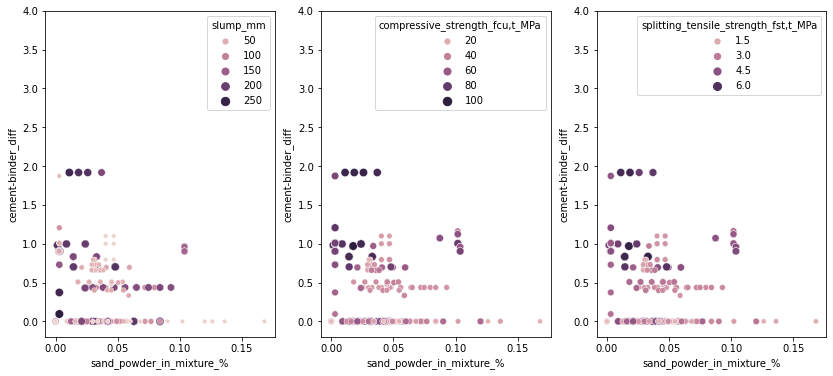

In [98]:
# creating 2nd order response
df['sand_powder_in_mixture_%'] = df['stone_powder_content_in_sand_%']*df['sand_ratio_%'] / 100**2

fig, axes = plt.subplots(1,3, figsize=(14,6))
sns.scatterplot(data=df, x='sand_powder_in_mixture_%', y='cement-binder_diff', 
                hue='slump_mm', size='slump_mm', ax=axes[0]).set_ylim(-0.2,4)
sns.scatterplot(data=df, x='sand_powder_in_mixture_%', y='cement-binder_diff',  
                hue='compressive_strength_fcu,t_MPa', size='compressive_strength_fcu,t_MPa', ax=axes[1]).set_ylim(-0.2,4)
sns.scatterplot(data=df, x='sand_powder_in_mixture_%', y='cement-binder_diff', 
                hue='splitting_tensile_strength_fst,t_MPa', size='splitting_tensile_strength_fst,t_MPa', ax=axes[2]).set_ylim(-0.2,4);

These scatter plots suggest that the datapoints resulting in the highest strength and largest slump are generally those with additional SCMs. It is unclear whether a higher % of stone powder in the overall mixture results in higher or lower strengths or slump. It is actually rather apparent from these scatter plots that there seems to be sparse representation of higher stone powder percentages in the presence of admixture.

For completeness, the individual single order responses for `sand ratio %` and `stone powder in sand %` have been plotted below. The top row, plotting `stone powder in the sand %`, is again highlighting a gap of higher stone percentages in the presence of SCMs. The second row is highlight how higher `sand ratio` percentages were mostly tested when in the presence of admixture.

This analysis gives further credence to preparing a fitted model, which may be able to tease apart the contributions of each process variable in a way which is difficult to do with visual analytics alone.

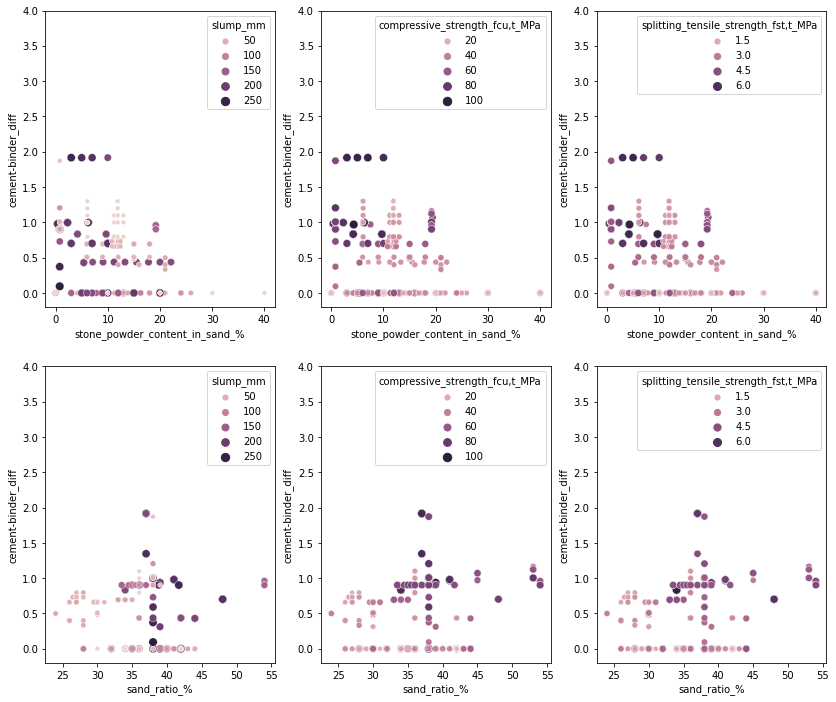

In [99]:
fig, axes = plt.subplots(2,3, figsize=(14,12))
sns.scatterplot(data=df, x='stone_powder_content_in_sand_%', y='cement-binder_diff', 
                hue='slump_mm', size='slump_mm', ax=axes[0][0]).set_ylim(-0.2,4)
sns.scatterplot(data=df, x='stone_powder_content_in_sand_%', y='cement-binder_diff', 
                hue='compressive_strength_fcu,t_MPa', size='compressive_strength_fcu,t_MPa', ax=axes[0][1]).set_ylim(-0.2,4)
sns.scatterplot(data=df, x='stone_powder_content_in_sand_%', y='cement-binder_diff', 
                hue='splitting_tensile_strength_fst,t_MPa', size='splitting_tensile_strength_fst,t_MPa', ax=axes[0][2]).set_ylim(-0.2,4)
sns.scatterplot(data=df,  x='sand_ratio_%', y='cement-binder_diff', 
                hue='slump_mm', size='slump_mm', ax=axes[1][0]).set_ylim(-0.2,4)
sns.scatterplot(data=df,  x='sand_ratio_%', y='cement-binder_diff', 
                hue='compressive_strength_fcu,t_MPa', size='compressive_strength_fcu,t_MPa', ax=axes[1][1]).set_ylim(-0.2,4)
sns.scatterplot(data=df,  x='sand_ratio_%', y='cement-binder_diff', 
                hue='splitting_tensile_strength_fst,t_MPa', size='splitting_tensile_strength_fst,t_MPa', ax=axes[1][2]).set_ylim(-0.2,4);

### Gaining a general understanding of each feature in the dataset

First, the response and process features will be separated.

In [100]:
# separating the process variables to be used in the model fit
# note that 'sand_powder_in_mixture_%' is being dropped as an automatic polynomial transformer will be applied to all features later.
X = df.drop(columns=y_vars+['Source', 'sand_powder_in_mixture_%'])

# separating the response-variables. when fitting the model(s), one feature at a time will be selected as a "y"
response_vars = df[y_vars]

It's generally a good idea to get a sense of the spread of values within each feature. Below are the histograms for the response-variables and for the process variables. Looks like slump is large skewed towards 50 mm while compressive and tensile strength have more normal distributions with medians centered around 30 and 3 MPa respectively.

The process variables have many irregular distributions and gaps. This is not suprising given that a lot of these features are process related. For example, the max diameter of the stone could be showing powder as sieved through different mesh-sizes. Any resulting stone sieved through a fixed mesh size could be of a max particle size _or below_. There looks to be maybe 3 modes for this histogram, around 40, 80, and maybe 120. 

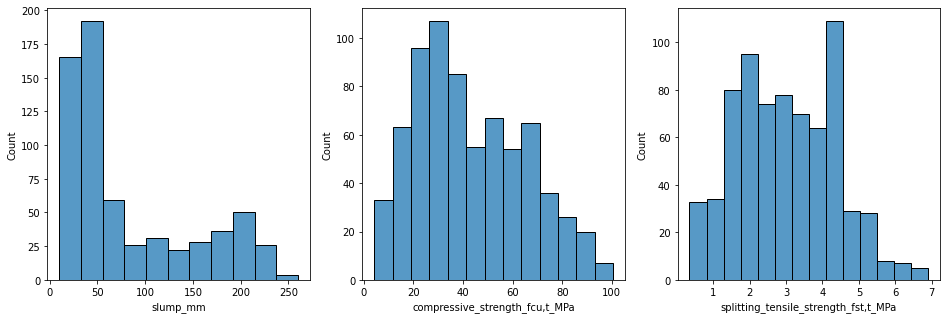

In [101]:
fig = plt.figure(1, figsize=(16,5))
Position = range(1,len(response_vars) + 1)
for i, feature in enumerate(response_vars.columns):
  ax = fig.add_subplot(1,3,Position[i])
  sns.histplot(data=response_vars[feature], ax=ax)

plt.show()

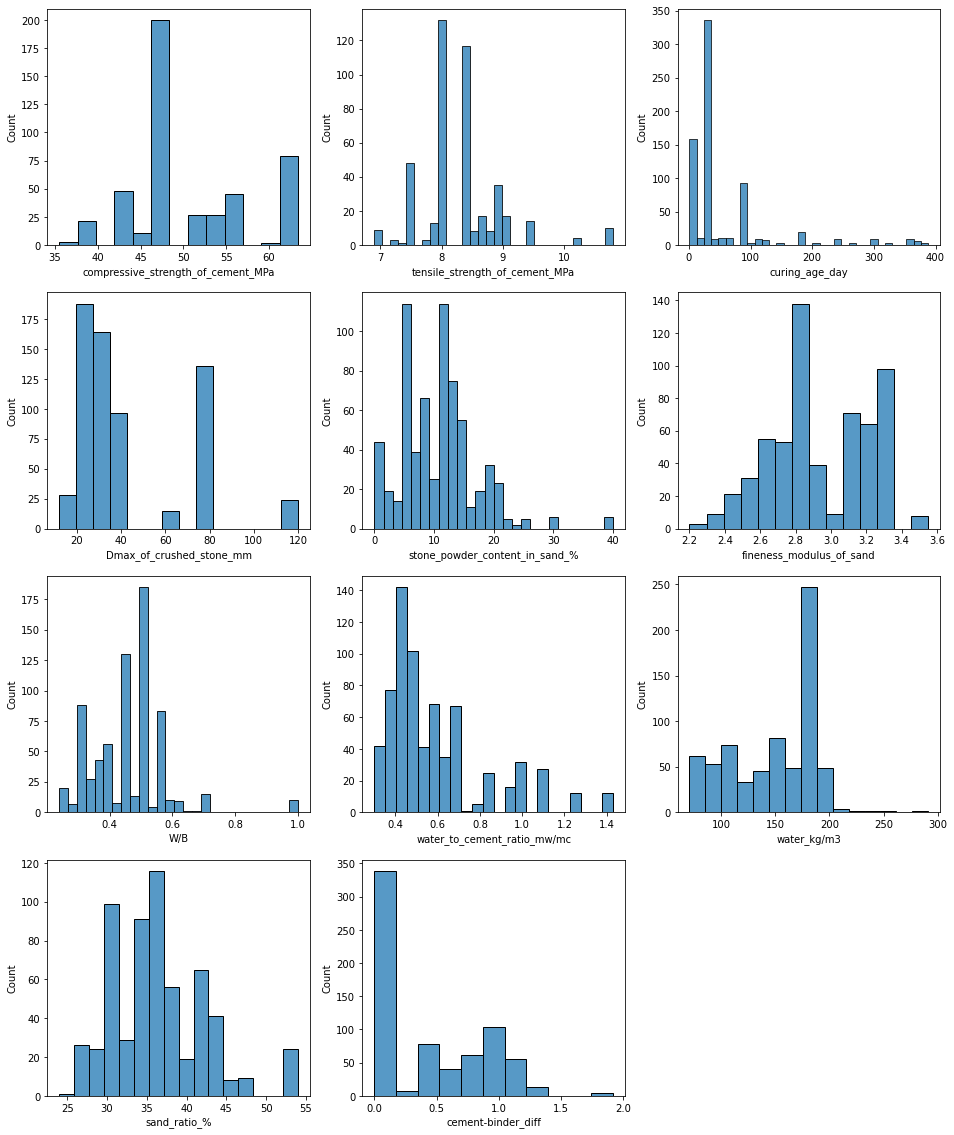

In [102]:
fig = plt.figure(1, figsize=(16,20))
Position = range(1,len(X) + 1)
for i, feature in enumerate(X.columns):
  ax = fig.add_subplot(4,3,Position[i])
  sns.histplot(data=X[feature], ax=ax)

plt.show()

Below are some "pair plots" of each response variable against the process variables. Pair plots are useful as they give us a sense of which process variables the response-variables are most sensitive to and how. "How" can mean:

1. strength of correlation,
1. whether the features are negatively or positively correlated, and 
1. in what mathematical-order of a response (first, second, etc) are two features correlated. 

Note that the bottom 3 rows of plots are the response-variables in relation to themselves.

Visually, it seems the `water to binder` and `water to cement` ratios have the strongest correlations with the response-variables. Water to cement may be a second order relationship. For this reason, and inspired by some of the previous analysis, a polynomial feature transformer will be used when fitting the model.

* **Column one** -   Slump
* **Column two** -   Compressive Strength
* **Column three** - Tensile Strength

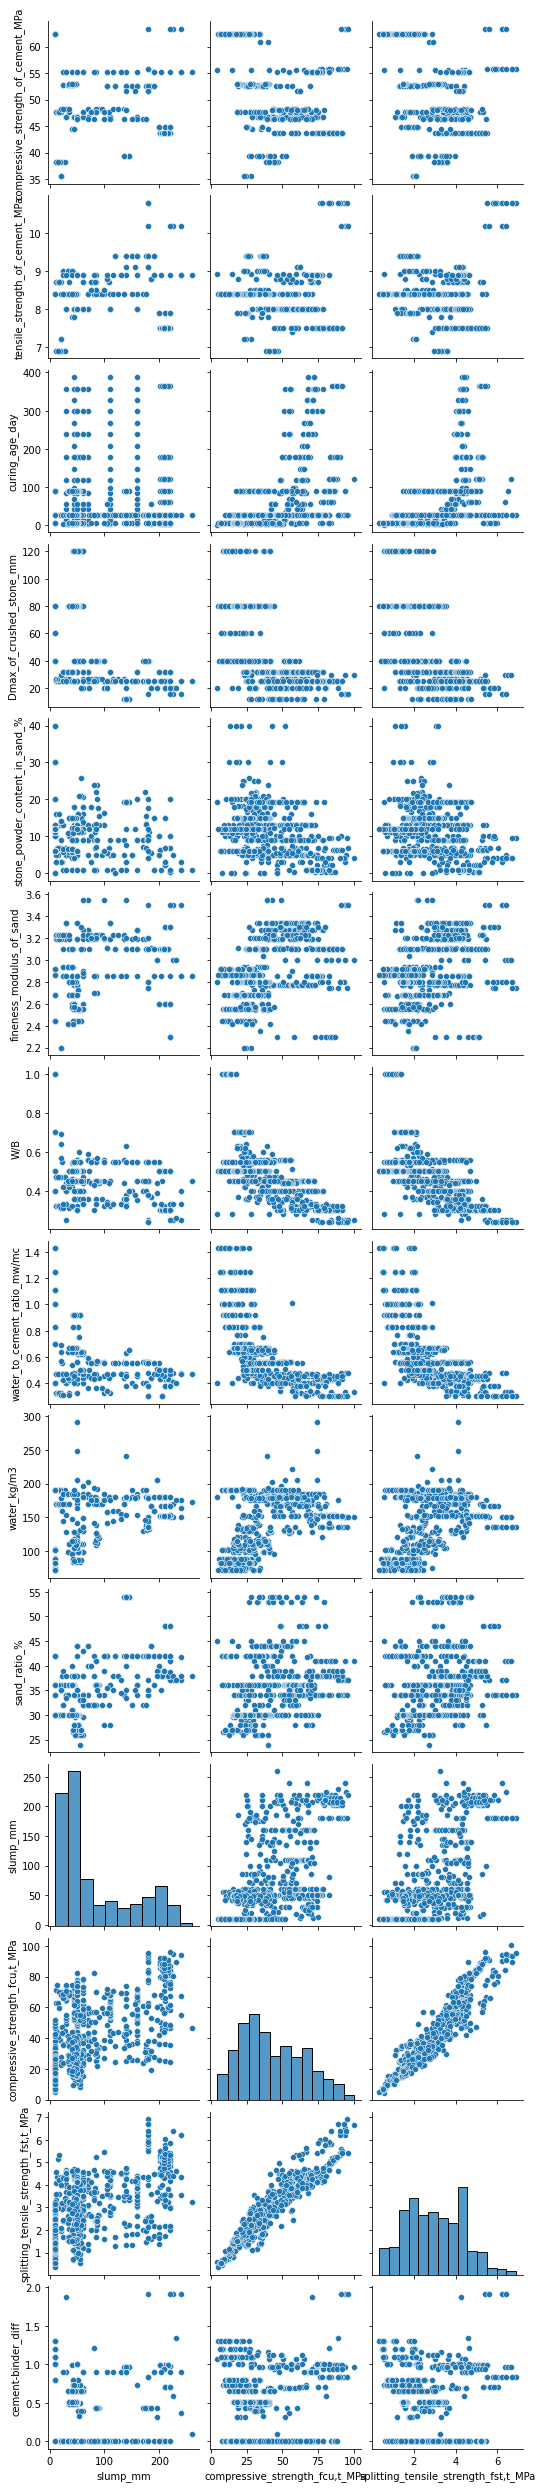

In [103]:
sns.pairplot(data=df.drop(columns=['Source', 'sand_powder_in_mixture_%']), x_vars=y_vars);

# Predictive Modeling

The paper provides formulas that relate compressive strength to tensile strength with two coefficients.

$$ f_{tensile} = af^b_{compressive}$$ (1)

It also looks into "forecasting" power functions that can predict long-term tensile strength based on 28 day-cured concrete's compressive strength and tensile stength. These functions take the form of:

$$ f_{tensile,t} = a* (1 + b*log(\frac{t}{28}))^c * f_{tensile,28}$$ (2)

where $f_{tensile,28}$ can be derived from the compressive strength at 28 days, per formula 1.

A simple formula like this may be desirable when quickly relating compressive strength the tensile. However, this does not provide a method of predicting compressive strength. It also does not tie in directly with process inputs, and thus the coefficients will need to be re-determined upon changing the process inputs. A more complex model based on process inputs describes a much larger process space. This eliminates the need to testing every single configuration of process inputs and can help guide further experimentation only in promising regions of the process space. In addition, this model based on process inputs can be used to better understand the effect of each process input on the material outputs.

The following section reports on the setup for a suite of **linear regressions** to predict:

1. compressive strength based on process inputs, reviewing the process inputs' importances
1. tensile strength based on process inputs and on process inputs + tensile strength

In [104]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

## Compressive Strength Model: Setup

In [105]:
X.columns

Index(['compressive_strength_of_cement_MPa', 'tensile_strength_of_cement_MPa',
       'curing_age_day', 'Dmax_of_crushed_stone_mm',
       'stone_powder_content_in_sand_%', 'fineness_modulus_of_sand', 'W/B',
       'water_to_cement_ratio_mw/mc', 'water_kg/m3', 'sand_ratio_%',
       'cement-binder_diff'],
      dtype='object')

In [106]:
# first testing compressive strength, as "slump" has some NaNs that must be filtered out
y = df[y_vars[1]]
print(y_vars[1])

compressive_strength_fcu,t_MPa


### Testing effectiveness of polynomial features

As mentioned in the data exploration, from the pair plots, it appears there may be some non-linear relationship and possibly interactions between relevent features. For this reason, it is of interested to test the fit of a linear regression without and with polynomial features included.

In [107]:
# KNNImputer fills in missing values in the process variables and should be noted as a potential limitation in the model where inaccuracy is introduced.
# values are filled in using a datapoint which is the closest in terms of other features.

compressive_model = make_pipeline(KNNImputer(), StandardScaler(), LinearRegression())
compressive_model.fit(X,y)
print(f'The model without polynomial features resulted in an R^2 of {round(compressive_model.score(X,y),3)}')

The model without polynomial features resulted in an R^2 of 0.813


In [108]:
# Note that PolynomialFeatures() comes after StandardScaler() as this will make the feature importances more interpretable
compressive_model = make_pipeline(KNNImputer(), StandardScaler(), PolynomialFeatures(), LinearRegression())
compressive_model.fit(X,y)
print(f'The model with polynomial features resulted in an R^2 of {round(compressive_model.score(X,y),3)}')

The model with polynomial features resulted in an R^2 of 0.945


**Interpretation**: Including polynomial features is highly effective and increases the R^2 value significantly. With an R^2 value of ~0.95, this suggests that it isn't necessary to use a more complex model like a random forest. However, a train-test split should be performed to ensure the modeling isn't **overfitting**, which results in a model that only applies to the data points that were used for training the model.

In [131]:
# incorporating a train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [132]:
compressive_model = make_pipeline(KNNImputer(), StandardScaler(), PolynomialFeatures(), LinearRegression())
compressive_model.fit(X_train,y_train)
print(f'''
The R^2 of the model fit of the training data is {round(compressive_model.score(X_train,y_train),3)}.
The hold-out test data resulted in an R^2 of {round(compressive_model.score(X_test,y_test),3)}.
''')


The R^2 of the model fit of the training data is 0.947.
The hold-out test data resulted in an R^2 of 0.924.



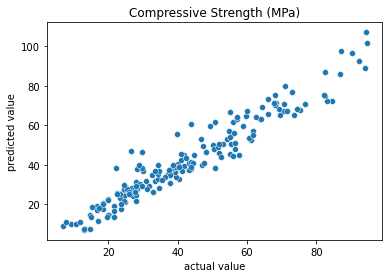

In [133]:
comp_strngth_preds = compressive_model.predict(X_test)
fig = sns.scatterplot(x=y_test,y=comp_strngth_preds)
plt.title('Compressive Strength (MPa)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

**Interpretation**: _The linear regression predictive models look useful and statistically sound._ The test score suggests that the model still performs well with a held-out test set; it's R^2 value is less than 0.04 lower than that of the model's fit and both are above 0.90. The residuals (the plot of the actual values vs the predicted values) also suggests a very linear trend with a fairly consistent amount of error as the strength values get larger (with slightly less error for compressive strengths below ~25 MPa). Note, there are a handful of outliers, but they aren't terrible far off from the trend.

For a more quantitative look at error, several error measurements are reported below:

In [112]:
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error, median_absolute_error

In [134]:
rmse = mean_squared_error(y_test,comp_strngth_preds,squared=False)
max_e = max_error(y_test,comp_strngth_preds)
mean_e = mean_absolute_error(y_test,comp_strngth_preds)
median_e = median_absolute_error(y_test,comp_strngth_preds)

print (f'''
The median error suggests that most points fall within an error range of {round(median_e, 3)}.
The mean error is {round(mean_e, 3)}.
The max error is {round(max_e, 3)}.
The root mean squared error is {round(rmse, 3)} and is used when it is desired to more heavily penalize outliers.
''')


The median error suggests that most points fall within an error range of 3.19.
The mean error is 4.361.
The max error is 20.73.
The root mean squared error is 5.784 and is used when it is desired to more heavily penalize outliers.



**Interpretation**: Generally, predicted values may be off about +/- 3.2 MPa, as seen by the median absolute error. The mean error is fairly close to the median, at ~4.4 MPa, which suggests there aren't a significant amount of outliers pulling the mean away from the median error. The max error is 21 MPa which is why the RMSE is slightly higher at 5.8 MPa. All these errors are relatively small but could potentially be improved with a more detailed dataset (for example, one that includes the admixture components).

## Extracting Process Input Feature Importance for Compressive Strength

The feature importance of each feature can guide our understanding of how significant the process input is in impacting the response variable, in this case compressive strength. Because of the way the predictive model was created, feature importances are roughly equated to the absolute values of their coefficients.

In [114]:
# SCRIPT TO EXTRACT COEFFICIENT AND FEATURE IMPORTANCES FOR EACH PROCESS VARIABLE

# Feature names from the polynomial feature transformer are saved as x{int}
poly_feature_names = compressive_model.steps[2][1].get_feature_names()
poly_feature_names = pd.Series(poly_feature_names)
# Preparing a mapping for each x{int}
x_list = [f'x{i}' for i in range(10)]
feature_dict = dict(zip(x_list,X.columns))
# replacing any mention of x{int} with it's mapped feature name
for x_name, feature in feature_dict.items():
    poly_feature_names = poly_feature_names.str.replace(x_name, feature)
poly_feature_names = poly_feature_names.str.replace(' ', ' * ')
# Retrieving the coefficients from the linear regression fit and pairing them with their features
coef_results = pd.DataFrame(poly_feature_names)
coef_results['coef'] = compressive_model.steps[3][1].coef_
# because features are scaled, the absolute value of their coefs are correlated to their importance
coef_results['importance'] = abs(coef_results['coef'])
coef_results = coef_results.rename(columns={0:'feature'})

In [135]:
coef_results = coef_results.sort_values(by='importance', ascending=False).reset_index().drop(columns='index')
coef_results.head(20)

,feature,coef,importance
0,water_to_cement_ratio_mw/mc,77.688559,77.688559
1,W/B,-71.461399,71.461399
2,tensile_strength_of_cement_MPa0,-55.263098,55.263098
3,W/B * tensile_strength_of_cement_MPa0,-21.421031,21.421031
4,curing_age_day,17.241258,17.241258
5,compressive_strength_of_cement_MPa * water_kg/m3,-14.999113,14.999113
6,compressive_strength_of_cement_MPa^2,-14.539252,14.539252
7,water_kg/m3 * tensile_strength_of_cement_MPa0,13.577346,13.577346
8,Dmax_of_crushed_stone_mm,-12.605453,12.605453
9,water_to_cement_ratio_mw/mc * tensile_strength...,-10.787038,10.787038


In [117]:
# for completeness, the intercept can be used to formulate the complete model
print(f"The model's intercept is {round(compressive_model.steps[3][1].intercept_,3)}")

The model's intercept is 53.718


**Interpretation**: The model may benefit from some regularization as it seems to be assigning a lot of importance to the water-binder ratio (the top 3-ranked features have feature importances which are much higher than the remaining features). This can be done in future iterations of this study.

Out of the 77 features (comprised of first order and second order interactions), the model suggest that the top three feature are all first-order, suggesting that these features alone have strong linear predictive power:

1. **water_to_cement_ratio_mw/mc**
1. **W/B**
1. **tensile_strength_of_cement_MPa**

The remaining highly ranked features are mostly 2nd order relationships with the exception of `curing_age`.

These top two ranked features illuminate how important the quantity of water is, though this is not a surprising phenomena when is comes to concrete. Interestingly, although this paper is exploring the quality of sand with addition of stone powder and its impact on concrete, any features related to sand or stone do not show up until feature importance rank 8, which is a first-order process input of `Dmax_of_crushed_stone_mm`. The next mention of "stone" or "sand" does not show up until rank 14. `Dmax_of_crushed_stone_mm` actually seems to have a fairly high importance ranking of 12.6 (it is 1E2 when most features are 1E1 or less). This importance ranking suggests that the morphology of the stone powder may be more important than the quantity itself. The sign of the coefficient suggests that larger diameters result in weaker strengths. Measuring max diameter is a fairly limited window into the effect of stone powder morphology on the resulting mechanical properties of concrete, but additional inputs characterizing the roughness of the powder particles could yield interesting results. Perhaps the way stone is ground is important to the resulting concrete.

In [137]:
coef_results[coef_results['feature'].str.contains('stone')].head()

,feature,coef,importance
8,Dmax_of_crushed_stone_mm,-12.605453,12.605453
14,Dmax_of_crushed_stone_mm * W/B,7.018276,7.018276
15,Dmax_of_crushed_stone_mm * tensile_strength_of...,6.239906,6.239906
20,tensile_strength_of_cement_MPa * Dmax_of_crush...,5.137807,5.137807
26,Dmax_of_crushed_stone_mm * fineness_modulus_of...,4.166682,4.166682


In [138]:
coef_results[coef_results['feature'].str.contains('sand')].head()

,feature,coef,importance
17,water_kg/m3 * sand_ratio_%,-5.577555,5.577555
23,compressive_strength_of_cement_MPa * sand_ratio_%,-4.777500,4.777500
26,Dmax_of_crushed_stone_mm * fineness_modulus_of...,4.166682,4.166682
27,stone_powder_content_in_sand_% * tensile_stren...,-4.164515,4.164515
28,fineness_modulus_of_sand * water_kg/m3,4.135574,4.135574


In [136]:
# for a look at just the original first-order features
coef_results[~coef_results['feature'].str.contains(' * |2')]

,feature,coef,importance
0,water_to_cement_ratio_mw/mc,7.768856e+01,7.768856e+01
1,W/B,-7.146140e+01,7.146140e+01
2,tensile_strength_of_cement_MPa0,-5.526310e+01,5.526310e+01
4,curing_age_day,1.724126e+01,1.724126e+01
8,Dmax_of_crushed_stone_mm,-1.260545e+01,1.260545e+01
19,water_kg/m3,-5.297946e+00,5.297946e+00
40,fineness_modulus_of_sand,2.281434e+00,2.281434e+00
43,compressive_strength_of_cement_MPa,-1.708149e+00,1.708149e+00
53,sand_ratio_%,-1.102616e+00,1.102616e+00
68,stone_powder_content_in_sand_%,-3.321758e-01,3.321758e-01


## Tensile Strength Model: Linking Two Models

FIX

The paper discusses the coefficients and resulting fit for several simple formulas, one for predicting tensile strength using the compressive strength as an input. This parametric formula is interesting because the paper asserts that it is difficult to measure tensile strength of concrete. The paper discusses two methods: a _direct tensile test_ and a _splitting tensile test_. The direct tensile test more accurately reflects the tensile properties as targeted in industry specifications. However, it is a challenging test step up. The splitting tensile test, though maybe not as accurate as the direct method, is simpler to set up and therefore is more widely adopted in research settings. However, if the need to test for tensile properties can be somewhat mitigated or streamlined with the use of a formula or--as this notebook is about to propose--a linear regression, this would only further simplify concrete characterization.

The approach below will use the compressive strength as an input to a similar linear regression as prepared above. First, model with be fit with just the process inputs to serve as a baseline. Next, a model will be fit using compressive strength as an input. It will start with the ground-truth compressive strengths for training, but shortly after, a function will port the results of the compressive strength model into the tensile strength model to simulate an applied workflow of predictive mechanical properties from process inputs.

### Baseline Tensile Model -- No Compressive Strength Data for Training

First, a model is fit on the same process variables use to fit the compressive strength model. The results of this model will serve as a comparison to the model that includes compressive strength as a process variable.

In [139]:
y = df[y_vars[2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [140]:
tensile_model2 = make_pipeline(KNNImputer(), StandardScaler(), PolynomialFeatures(), LinearRegression())
tensile_model2.fit(X_train,y_train)
print(f'''
The R^2 of the model fit of the training data is {round(tensile_model2.score(X_train,y_train),3)}.
The hold-out test data resulted in an R^2 of {round(tensile_model2.score(X_test,y_test),3)}.
''')


The R^2 of the model fit of the training data is 0.9.
The hold-out test data resulted in an R^2 of 0.832.



### Tensile Model Using Compressive Strength as a Process Variable

Next, a new model is fit using the ground-truth compressive strength for each datapoint as a process variable. As seen by the resulting scores, the model does perform better than the baseline both in the training dataset and the holdout set. This means that the compressive strength holds some predictive power when it comes to tensile strength which the pure process inputs cannot predict.

In [141]:
X['compressive_strength_fcu,t_MPa'] = df['compressive_strength_fcu,t_MPa']
y = df[y_vars[2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [142]:
tensile_model = make_pipeline(KNNImputer(), StandardScaler(), PolynomialFeatures(), LinearRegression())
tensile_model.fit(X_train,y_train)
print(f'''
The R^2 of the model fit of the training data is {round(tensile_model.score(X_train,y_train),3)}.
The hold-out test data resulted in an R^2 of {round(tensile_model.score(X_test,y_test),3)}.
''')


The R^2 of the model fit of the training data is 0.952.
The hold-out test data resulted in an R^2 of 0.914.



## Mocking a Predictive Workflow

Below is a programmatic-function that uses the final compressive strength model and tensile strength model to take "unseen data" (test data) and predict _both_ the compressive strength _and_ the tensile strength, using the predicted compressive strength as an input for the tensile model. 

The test results from the compression model actually yielded better predictions than the previous test holdout set. The tensile test results were lower than that of the fitted model; this is most likely because of the compounding error from the compression strength model and the tensile strength model. However, the test results of the tensile strength still beats the baseline by 0.03.

In [153]:
def predict_comp_and_tens(tens_X,tens_y,comp_model,tens_model, output=True):
    comp_X = tens_X.drop(columns=['compressive_strength_fcu,t_MPa'])
    comp_y = tens_X['compressive_strength_fcu,t_MPa']
    comp_score = round(comp_model.score(comp_X, comp_y),3)
    if output:
        print(f"Compression model R^2 test results: {comp_score}")
    tens_X = tens_X.copy()
    tens_X['compressive_strength_fcu,t_MPa'] = comp_model.predict(comp_X)
    tens_score = round(tens_model.score(tens_X,tens_y),3)
    if output:
        print(f"Tensile model R^2 test results: {tens_score}")  
    return comp_model.predict(comp_X), tens_model.predict(tens_X), comp_score, tens_score

In [154]:
comp_preds, tens_preds, *scores = predict_comp_and_tens(X_test, y_test, compressive_model, tensile_model)

Compression model R^2 test results: 0.924
Tensile model R^2 test results: 0.864


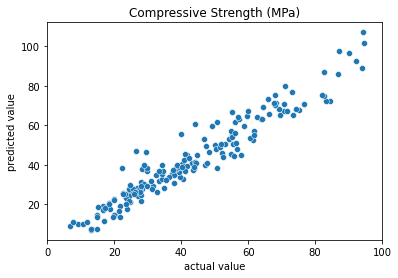

In [145]:
fig = sns.scatterplot(x=X_test['compressive_strength_fcu,t_MPa'],y=comp_preds).set_xlim(0,100)
plt.title('Compressive Strength (MPa)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

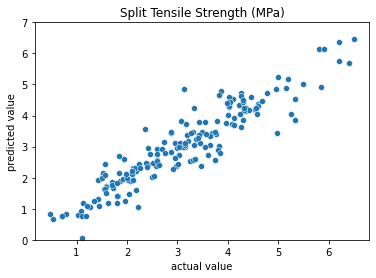

In [146]:
fig = sns.scatterplot(x=y_test,y=tens_preds).set_ylim(0,7)
plt.title('Split Tensile Strength (MPa)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

# Comparing Results to the Formulas from the Paper

The paper presents on the fit of their formula on tensile strength for curing days of quantities 3, 7, 28, 90, and 180. It also presents the fit for all the data points together. When looking at all the datapoints, their formula achieved and R^2 of 0.858; the tensile strength predictions using the workflow above has a better fit of 0.864. However, it must be kept in mind that technically, for an apples-to-apples comparison, we would both need to be using an adjusted R^2 value, as the model in this notebook has more terms. Still, this value serves as an interesting qualitative comparison at the very least. 

To match the paper, the R^2 values of all the data points with these specific curing times have been calculated below. The model in this notebook yields higher tensile R^2 values for all but the datapoints with a cure time of 3 days. This may indicate that a significant portion of the model's error comes from poorly describing points with low cure times. What is also interesting is the results for 180. This subset of data only has 11 datapoints and had the lowest R^2 value in the paper of 0.560. The model here still produces a low score of 0.776, but it is significantly higher than that of the paper.

In [160]:
curing_times = [3,7,28,90,180]
data_dict = {}
for time in curing_times:
    X_time = X[X['curing_age_day'] == time]
    y_time = y.iloc[X_time.index]
    comp_preds, tens_preds, comp_score, tens_score = predict_comp_and_tens(X_time, y_time, 
                                                                           compressive_model, 
                                                                           tensile_model, output = False)
    data_dict[time] = (len(X_time), comp_score, tens_score)
cure_df = pd.DataFrame(data_dict).T
cure_df = cure_df.rename(columns=dict(zip(cure_df.columns, ['qty_of_datapoints', 'compression_test_^r2','tensile_test_^r2'])))
cure_df

,qty_of_datapoints,compression_test_^r2,tensile_test_^r2
3,27.0,0.301,0.210
7,130.0,0.948,0.888
28,333.0,0.927,0.854
90,83.0,0.941,0.920
180,11.0,0.909,0.634


The paper also fits several power functions to predict the long term tensile strength from the 28 day-cured tensile results. However, this functionality does not apply to the fit models. A different model could be prepared as a "forecaster". This model is looking a pure process inputs to predict mechanical properties.

# Conclusions

* From the exploratory analysis, it appears that the addition of stone powder does potentially negatively impact both the compressive strength and tensile strength. However, as exposed in the exploration, the dataset is missing some critical information about what SCMs or other admixtures were added to each mixture. For this reason, the results are inconclusive.
* For improved results, in both modeling and through descriptive statistics, it would be best to generate a dataset with the admixtures included and with a better spread of mixtures with varying stone powder % and various admixtures.
* A predictive linear regression appears to be a highly effective method of predicting both the compression strength and the tensile strength (from both ground truth and predicted compression strengths)
* The linear regression fit best when polynomial features were used. However, for future models, regularization may want to be used. In addition, it is suggested to trim some of the features for the sake of interpretability. 
* From the ranked feature importances, when it comes to manufactured sand, it appears that the max diameter of the stone powder is the most highly ranked and reoccuring feature. Larger diameters of stone result in lower strength. This begs for further experimentation to be done on powder morphology characteristics and their results of mechanical properties of concrete.